<font color="blue">**Student Name:** Tin Yan Cheung</font>

In [13]:
import numpy as np
import scipy as sp
from scipy import io
import cv2 as cv 
import matplotlib.pyplot as plt
import pylab
import os # for reading all files in a folder
pylab.rcParams['figure.figsize'] = (5.0, 5.0)

# Part H: Tracking and Homographies

In this part we use Practical 7c to track the positions of the four corners of the square and project a cube into the images. 

TO DO: QUESTIONS TO THINK ABOUT...

- Do the results look realistic? 
- If not then what factors do you think might be causing this


TO DO: your routines for computing a homography and extracting a valid rotation and translation go in the code below. Tips:
- you may define functions for T and H matrices respectively.
- you may need to turn the points into homogeneous form before any other computation. 
- you may need to solve a linear system in Ah = 0 form. Write your own routines or using the builtin function 'svd'. 
- you may apply the direct linear transform (DLT) algorithm to recover the best homography H.
- you may explain what & why you did in the report.


In [14]:
#Likelihood function is simple patch similarity

def computeLikelihood(image, template):
    #opencv's available methods - experiment with these
    #careful what range the output is!
    methods = [cv.TM_CCOEFF, cv.TM_CCOEFF_NORMED, cv.TM_CCORR,
            cv.TM_CCORR_NORMED, cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]
    
    likelihood = cv.matchTemplate(image[:,:,2], template, methods[0])
    # (You can also try converting the image to greyscale instead of using the third channel as above with 
    # cv.cvtColor(image, cv.COLOR_BGR2GRAY))
    
    #we can pad to make this the size of the input image (for easier indexing)   
    pad_first = int(template.shape[0])
    pad_second = int(template.shape[1])
    pad_amounts = ((0, pad_first-1), (0, pad_second-1))
    likelihood = np.pad(likelihood, pad_amounts, 'constant')
    likelihood[likelihood<0] = 0 # to avoid negative weights 
    
    # apply a 10x10 averaging filter for stability. You can experiment with different sizes. 
    kernel = np.ones((10,10),np.float32)/100
    smoothed = cv.filter2D(likelihood,-1,kernel) 
    return smoothed 

# TO DO: Copy and paste the function HW2_Practical7c in here. 

def HW2_Practical7c(corner):
    template = sp.io.loadmat(corner+'.mat')['pixelsTemplate']
    #let's show the template
    print('We are matching this template with shape: ', template.shape)
    plt.imshow(template)
    plt.show()

    # Load all images in folder
    images = []
    iFrame = 0
    folder = 'Pattern01/'
    lst = os.listdir(folder)
    lst.sort()

    for frameNum in lst:
        images.append(cv.imread(folder+frameNum))
        iFrame += 1
    # plot first image 
    plt.imshow(images[0])
    plt.show()

    imgHeight, imgWidth, colors = images[0].shape
    numParticles = 2000;
    weight_of_samples = np.ones((numParticles,1))

    # TO DO: normalize the weights (may be trivial this time) [done]
    weight_of_samples = weight_of_samples/weight_of_samples.sum() #replace this 

    # Initialize which samples from "last time" we want to propagate: all of
    # them!:
    samples_to_propagate = range(0, numParticles)


    # ============================
    # NOT A TO DO: You don't need to change the code below, but eventually you may
    # want to vary the number of Dims (compare for example to lab 9b) 
    numDims_w = 2;
    # Here we randomly initialize some particles throughout the space of w:
    particles_old = np.random.rand(numParticles, numDims_w)
    particles_old[:,0] = particles_old[:,0] * imgHeight
    particles_old[:,1] = particles_old[:,1] * imgWidth
    # ============================

    #Initialize a temporary array r to store the per-frame MAP estimate of w. This is what we'll return in the end.
    r = np.zeros((iFrame, numDims_w));

    for iTime in range(iFrame):
        print('Processing Frame', iTime)

        # Only print some selected frames: first, second, half-way, last
        if iTime in [0, int(iFrame/2)-1,iFrame-1]:
            printFrame = True
        else:
            printFrame = False

        # TO DO: compute the cumulative sume of the weights. [done]
        cum_hist_of_weights = np.cumsum(weight_of_samples) # replace this
        #print(weight_of_samples)


        # ==============================================================
        # Resample the old distribution at time t-1, and select samples, favoring
        # those that had a higher posterior probability.
        # ==============================================================
        samples_to_propagate = np.zeros(numParticles, dtype=np.int32)

        # Pick random thresholds in the cumulative probability's range [0,1]:
        some_threshes = np.random.rand(numParticles)


        # For each random threshold, find which sample in the ordered set is
        # the first one to push the cumulative probability above that
        # threshold, e.g. if the cumulative histogram goes from 0.23 to 0.26
        # between the 17th and 18th samples in the old distribution, and the
        # threshold is 0.234, then we'll want to propagate the 18th sample's w
        # (i.e. particle #18).

        for sampNum in range(numParticles): 
            thresh = some_threshes[sampNum]
            for index in range (numParticles):
                if cum_hist_of_weights[index] > thresh:
                    break
            samples_to_propagate[sampNum] = index

        # Note: it's ok if some of the old particles get picked repeatedly, while
        # others don't get picked at all.


        # =================================================
        # Visualize if you want
        # =================================================
        # plt.title('Cumulative histogram of probabilities for sorted list of particles')
        # plt.plot(np.zeros(numParticles), some_threshes,'b.')
        # plt.plot(range(0, numParticles), cum_hist_of_weights, 'rx-')
        # which_sample_ids = np.unique(samples_to_propagate)
        # how_many_of_each = np.bincount(np.ravel(samples_to_propagate))
        # for k in range(len(which_sample_ids)):
        #    plt.plot(which_sample_ids[k], 0, 'bo-', markersize = 3 * how_many_of_each[k], markerfacecolor='white')
        # plt.xlabel('Indeces of all available samples, with larger blue circles for frequently re-sampled particles\n(Iteration %01d)' % iTime)
        # plt.ylabel('Cumulative probability');
        # plt.show()
        # =================================================
        # =================================================

        # Predict where the particles we sampled from the old distribution of 
        # state-space will go in the next time-step. This means we have to apply 
        # the motion model to each old sample.
        particles_new = np.zeros_like(particles_old)
        for particleNum in range(numParticles):
            # TO DO: Incorporate some noise, e.g. Gaussian noise with std 20,
            # into the current location (particles_old), to give a Brownian
            # motion model.
            particles_new[particleNum, :] =  particles_old[samples_to_propagate[particleNum],:] + np.random.normal(0,20,(particles_old[samples_to_propagate[particleNum],:]).shape) # replace this 
            
        # TO DO: Not initially, but change the motion model above to have
        # different degrees of freedom, and optionally completely different
        # motion models. See Extra Credit for more instructions.

        #calculate likelihood function
        likelihood = computeLikelihood(images[iTime], template)


        if printFrame:
            #plot results
            f, axarr = plt.subplots(1, 2)
            axarr[0].imshow(images[iTime])
            axarr[0].set_title('Particles')
            # now draw the particles onto the image
            axarr[0].plot(particles_new[:,1]+template.shape[1]/2, particles_new[:,0]+template.shape[0]/2, 'rx')

            #plot the likelihood
            axarr[1].imshow(likelihood)
            axarr[1].set_title('Likelihood')





        # From here we incorporate the data for the new state (time t):
        # The new particles accompanying predicted locations in state-space
        # for time t, are missing their weights: how well does each particle
        # explain the observations x_t?
        for particleNum in range(numParticles):

            # Convert the particle from state-space w to measurement-space x:
            # Note: that step is trivial here since both are in 2D space of image
            # coordinates

            # Within the loop, we evaluate the likelihood of each particle:
            particle = particles_new[particleNum, :]
            # Check that the predicted location is a place we can really evaluate
            # the likelihood.
            inFrame = particle[0] >= 0.0 and  particle[0] <= imgHeight and particle[1] >= 0.0 and particle[1] <= imgWidth
            if inFrame:
                minX = particle[1]
                minY = particle[0]

                weight_of_samples[particleNum] = likelihood[int(minY), int(minX)]

            else:
                weight_of_samples[particleNum] = 0.0

        # TO DO: normalize the weights [done]
        weight_of_samples = weight_of_samples/weight_of_samples.sum() # replace this
        
        # find the location of the particle with highest weight
        indices = np.argsort(weight_of_samples,0)
        bestScoringParticles = particles_new[np.squeeze(indices[-15:]), :]
       
        # Return the MAP of middle position. Add template.shape/2 because matchTemplate finds the position of the upper left corner 
        # of the template. We want to plot the centre of the template. 
        r[iTime,:] = bestScoringParticles[-1,1]+template.shape[1]/2,bestScoringParticles[-1,0]+template.shape[0]/2
        
        if printFrame:
            plt.plot(bestScoringParticles[-1:,1], bestScoringParticles[-1:,0], 'rx')
            print(r[iTime,:])   
            plt.show()

            #print the original image and the position of the tracked corner.
            plt.imshow(images[iTime])
            plt.plot(r[iTime,0],r[iTime,1],'rx')
            plt.show()

        # Now we're done updating the state for time t. 
        # For Condensation, just clean up and prepare for the next round of 
        # predictions and measurements:
        particles_old = particles_new

    return r

We are matching this template with shape:  (25, 28)


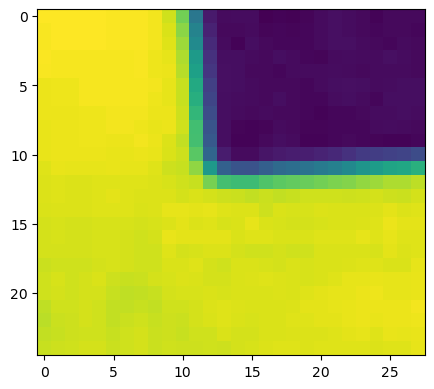

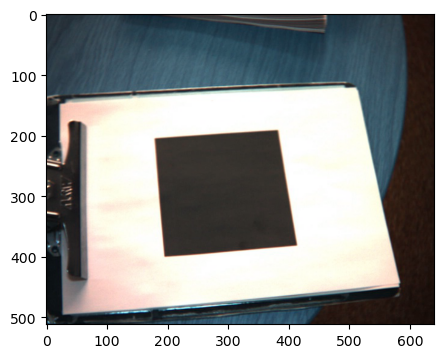

Processing Frame 0
[563.23398518 347.92180961]


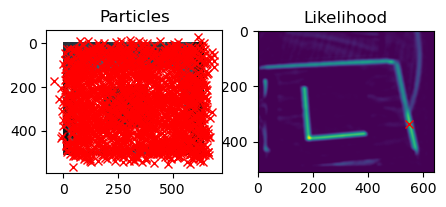

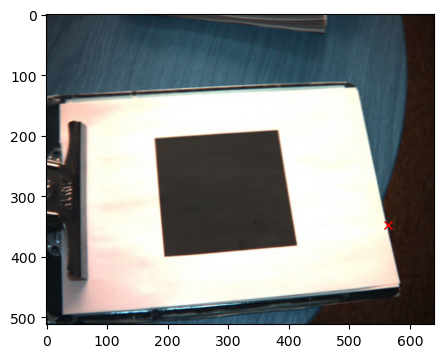

Processing Frame 1
Processing Frame 2
Processing Frame 3
Processing Frame 4
Processing Frame 5
Processing Frame 6
Processing Frame 7
Processing Frame 8
Processing Frame 9
Processing Frame 10
Processing Frame 11
Processing Frame 12
Processing Frame 13
Processing Frame 14
Processing Frame 15
Processing Frame 16
Processing Frame 17
Processing Frame 18
Processing Frame 19
Processing Frame 20
Processing Frame 21
Processing Frame 22
Processing Frame 23
Processing Frame 24
Processing Frame 25
Processing Frame 26
Processing Frame 27
Processing Frame 28
Processing Frame 29
Processing Frame 30
Processing Frame 31
Processing Frame 32
Processing Frame 33
Processing Frame 34
Processing Frame 35
Processing Frame 36
Processing Frame 37
Processing Frame 38
Processing Frame 39
Processing Frame 40
Processing Frame 41
Processing Frame 42
Processing Frame 43
Processing Frame 44
Processing Frame 45
Processing Frame 46
Processing Frame 47
Processing Frame 48
Processing Frame 49
Processing Frame 50
Processin

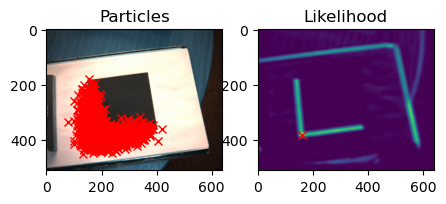

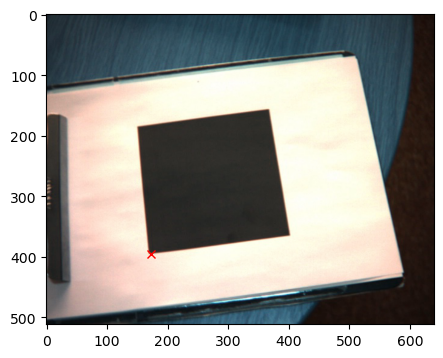

Processing Frame 75
Processing Frame 76
Processing Frame 77
Processing Frame 78
Processing Frame 79
Processing Frame 80
Processing Frame 81
Processing Frame 82
Processing Frame 83
Processing Frame 84
Processing Frame 85
Processing Frame 86
Processing Frame 87
Processing Frame 88
Processing Frame 89
Processing Frame 90
Processing Frame 91
Processing Frame 92
Processing Frame 93
Processing Frame 94
Processing Frame 95
Processing Frame 96
Processing Frame 97
Processing Frame 98
Processing Frame 99
Processing Frame 100
Processing Frame 101
Processing Frame 102
Processing Frame 103
Processing Frame 104
Processing Frame 105
Processing Frame 106
Processing Frame 107
Processing Frame 108
Processing Frame 109
Processing Frame 110
Processing Frame 111
Processing Frame 112
Processing Frame 113
Processing Frame 114
Processing Frame 115
Processing Frame 116
Processing Frame 117
Processing Frame 118
Processing Frame 119
Processing Frame 120
Processing Frame 121
Processing Frame 122
Processing Frame 

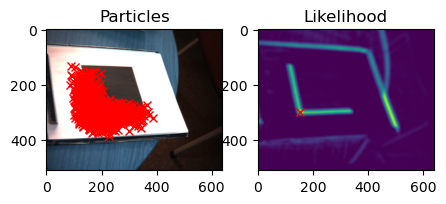

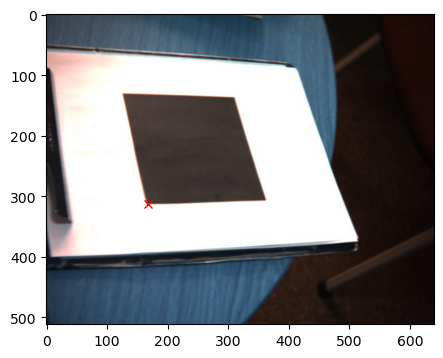

We are matching this template with shape:  (29, 29)


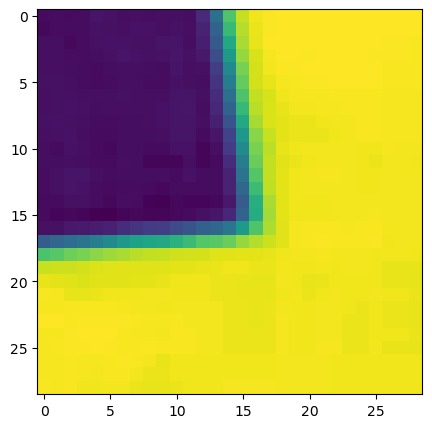

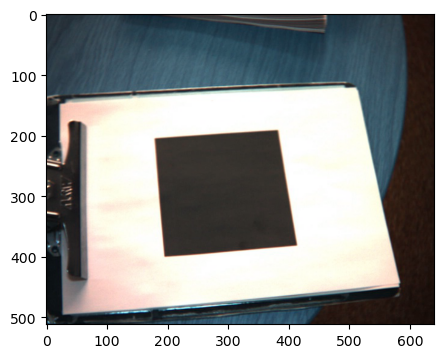

Processing Frame 0
[410.62229978 379.50389773]


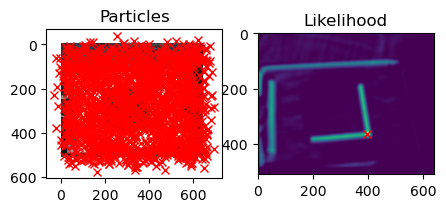

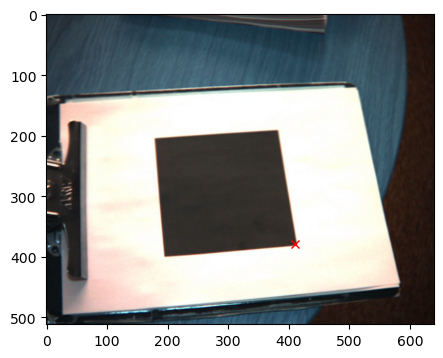

Processing Frame 1
Processing Frame 2
Processing Frame 3
Processing Frame 4
Processing Frame 5
Processing Frame 6
Processing Frame 7
Processing Frame 8
Processing Frame 9
Processing Frame 10
Processing Frame 11
Processing Frame 12
Processing Frame 13
Processing Frame 14
Processing Frame 15
Processing Frame 16
Processing Frame 17
Processing Frame 18
Processing Frame 19
Processing Frame 20
Processing Frame 21
Processing Frame 22
Processing Frame 23
Processing Frame 24
Processing Frame 25
Processing Frame 26
Processing Frame 27
Processing Frame 28
Processing Frame 29
Processing Frame 30
Processing Frame 31
Processing Frame 32
Processing Frame 33
Processing Frame 34
Processing Frame 35
Processing Frame 36
Processing Frame 37
Processing Frame 38
Processing Frame 39
Processing Frame 40
Processing Frame 41
Processing Frame 42
Processing Frame 43
Processing Frame 44
Processing Frame 45
Processing Frame 46
Processing Frame 47
Processing Frame 48
Processing Frame 49
Processing Frame 50
Processin

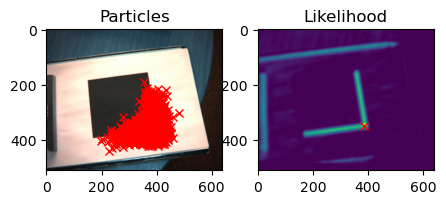

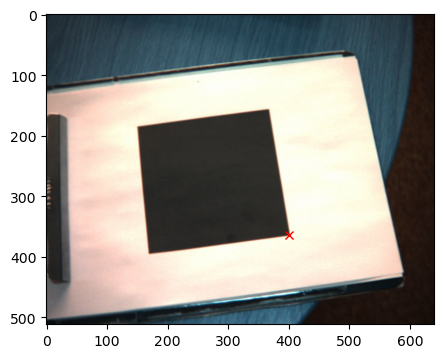

Processing Frame 75
Processing Frame 76
Processing Frame 77
Processing Frame 78
Processing Frame 79
Processing Frame 80
Processing Frame 81
Processing Frame 82
Processing Frame 83
Processing Frame 84
Processing Frame 85
Processing Frame 86
Processing Frame 87
Processing Frame 88
Processing Frame 89
Processing Frame 90
Processing Frame 91
Processing Frame 92
Processing Frame 93
Processing Frame 94
Processing Frame 95
Processing Frame 96
Processing Frame 97
Processing Frame 98
Processing Frame 99
Processing Frame 100
Processing Frame 101
Processing Frame 102
Processing Frame 103
Processing Frame 104
Processing Frame 105
Processing Frame 106
Processing Frame 107
Processing Frame 108
Processing Frame 109
Processing Frame 110
Processing Frame 111
Processing Frame 112
Processing Frame 113
Processing Frame 114
Processing Frame 115
Processing Frame 116
Processing Frame 117
Processing Frame 118
Processing Frame 119
Processing Frame 120
Processing Frame 121
Processing Frame 122
Processing Frame 

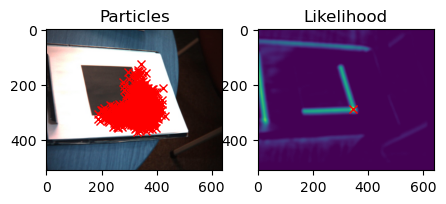

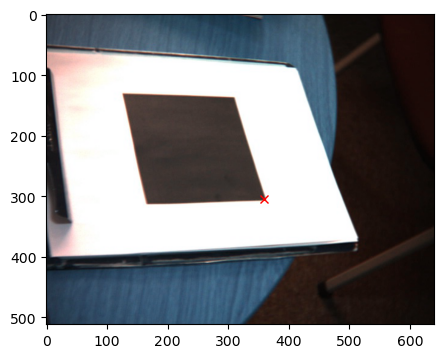

We are matching this template with shape:  (25, 28)


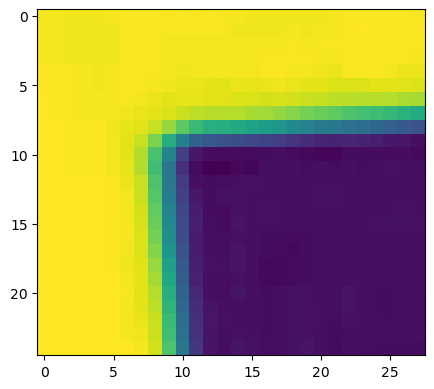

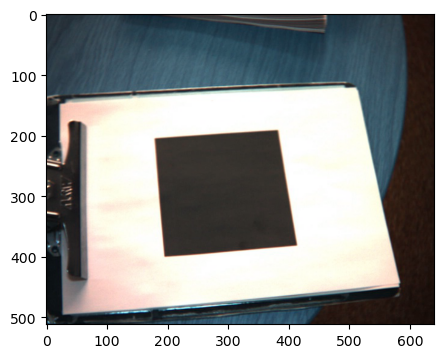

Processing Frame 0
[182.17001074 209.44806717]


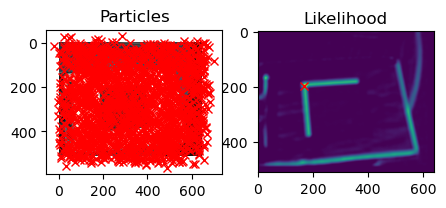

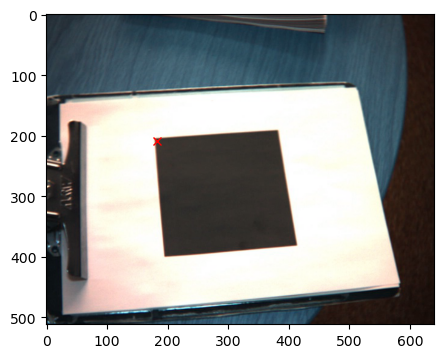

Processing Frame 1
Processing Frame 2
Processing Frame 3
Processing Frame 4
Processing Frame 5
Processing Frame 6
Processing Frame 7
Processing Frame 8
Processing Frame 9
Processing Frame 10
Processing Frame 11
Processing Frame 12
Processing Frame 13
Processing Frame 14
Processing Frame 15
Processing Frame 16
Processing Frame 17
Processing Frame 18
Processing Frame 19
Processing Frame 20
Processing Frame 21
Processing Frame 22
Processing Frame 23
Processing Frame 24
Processing Frame 25
Processing Frame 26
Processing Frame 27
Processing Frame 28
Processing Frame 29
Processing Frame 30
Processing Frame 31
Processing Frame 32
Processing Frame 33
Processing Frame 34
Processing Frame 35
Processing Frame 36
Processing Frame 37
Processing Frame 38
Processing Frame 39
Processing Frame 40
Processing Frame 41
Processing Frame 42
Processing Frame 43
Processing Frame 44
Processing Frame 45
Processing Frame 46
Processing Frame 47
Processing Frame 48
Processing Frame 49
Processing Frame 50
Processin

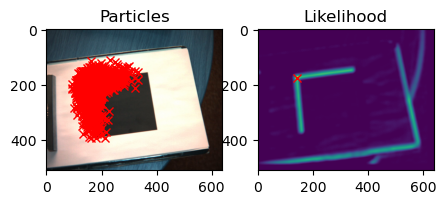

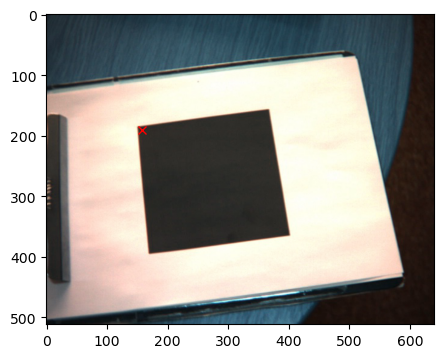

Processing Frame 75
Processing Frame 76
Processing Frame 77
Processing Frame 78
Processing Frame 79
Processing Frame 80
Processing Frame 81
Processing Frame 82
Processing Frame 83
Processing Frame 84
Processing Frame 85
Processing Frame 86
Processing Frame 87
Processing Frame 88
Processing Frame 89
Processing Frame 90
Processing Frame 91
Processing Frame 92
Processing Frame 93
Processing Frame 94
Processing Frame 95
Processing Frame 96
Processing Frame 97
Processing Frame 98
Processing Frame 99
Processing Frame 100
Processing Frame 101
Processing Frame 102
Processing Frame 103
Processing Frame 104
Processing Frame 105
Processing Frame 106
Processing Frame 107
Processing Frame 108
Processing Frame 109
Processing Frame 110
Processing Frame 111
Processing Frame 112
Processing Frame 113
Processing Frame 114
Processing Frame 115
Processing Frame 116
Processing Frame 117
Processing Frame 118
Processing Frame 119
Processing Frame 120
Processing Frame 121
Processing Frame 122
Processing Frame 

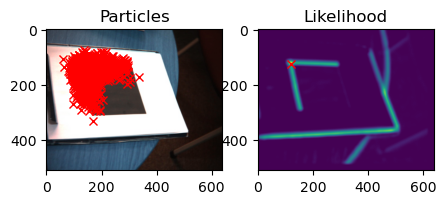

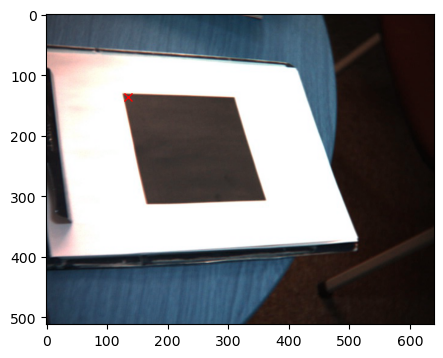

We are matching this template with shape:  (28, 30)


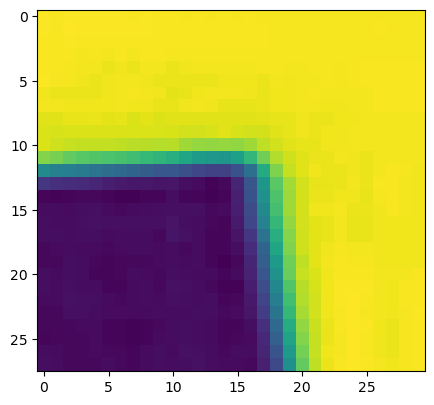

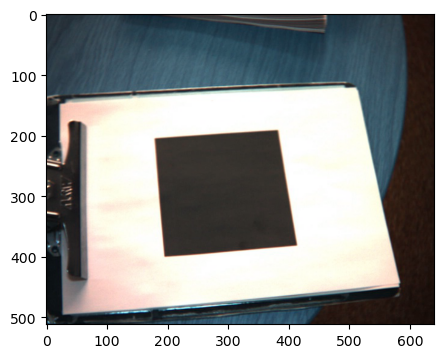

Processing Frame 0
[384.7682926  202.32010826]


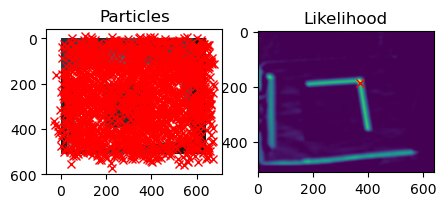

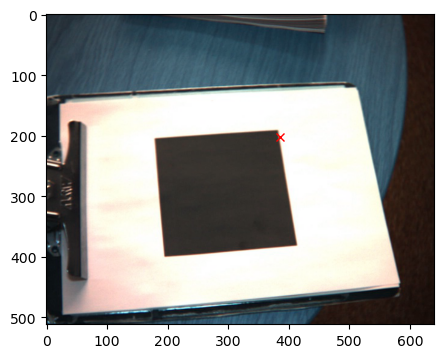

Processing Frame 1
Processing Frame 2
Processing Frame 3
Processing Frame 4
Processing Frame 5
Processing Frame 6
Processing Frame 7
Processing Frame 8
Processing Frame 9
Processing Frame 10
Processing Frame 11
Processing Frame 12
Processing Frame 13
Processing Frame 14
Processing Frame 15
Processing Frame 16
Processing Frame 17
Processing Frame 18
Processing Frame 19
Processing Frame 20
Processing Frame 21
Processing Frame 22
Processing Frame 23
Processing Frame 24
Processing Frame 25
Processing Frame 26
Processing Frame 27
Processing Frame 28
Processing Frame 29
Processing Frame 30
Processing Frame 31
Processing Frame 32
Processing Frame 33
Processing Frame 34
Processing Frame 35
Processing Frame 36
Processing Frame 37
Processing Frame 38
Processing Frame 39
Processing Frame 40
Processing Frame 41
Processing Frame 42
Processing Frame 43
Processing Frame 44
Processing Frame 45
Processing Frame 46
Processing Frame 47
Processing Frame 48
Processing Frame 49
Processing Frame 50
Processin

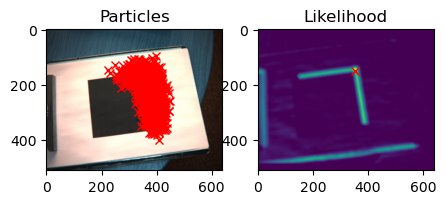

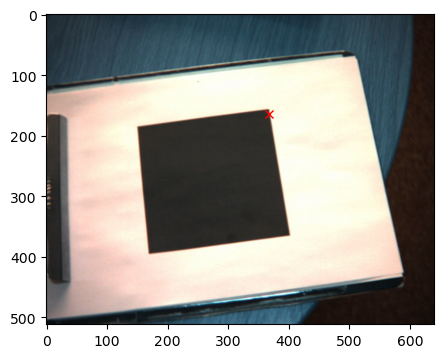

Processing Frame 75
Processing Frame 76
Processing Frame 77
Processing Frame 78
Processing Frame 79
Processing Frame 80
Processing Frame 81
Processing Frame 82
Processing Frame 83
Processing Frame 84
Processing Frame 85
Processing Frame 86
Processing Frame 87
Processing Frame 88
Processing Frame 89
Processing Frame 90
Processing Frame 91
Processing Frame 92
Processing Frame 93
Processing Frame 94
Processing Frame 95
Processing Frame 96
Processing Frame 97
Processing Frame 98
Processing Frame 99
Processing Frame 100
Processing Frame 101
Processing Frame 102
Processing Frame 103
Processing Frame 104
Processing Frame 105
Processing Frame 106
Processing Frame 107
Processing Frame 108
Processing Frame 109
Processing Frame 110
Processing Frame 111
Processing Frame 112
Processing Frame 113
Processing Frame 114
Processing Frame 115
Processing Frame 116
Processing Frame 117
Processing Frame 118
Processing Frame 119
Processing Frame 120
Processing Frame 121
Processing Frame 122
Processing Frame 

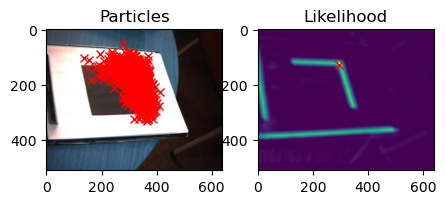

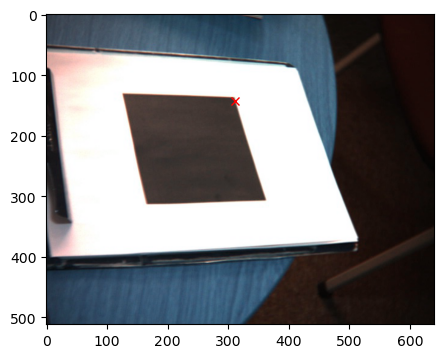

In [15]:
# instead of running the code here, you can also save the output of each function in a numpy array in HW2_Practical7c 
# and load it here. This could be handy if you need different hyperparameters for each corner.

LLs = HW2_Practical7c( 'll' )
LRs = HW2_Practical7c( 'lr' )
ULs = HW2_Practical7c( 'ul' )
URs = HW2_Practical7c( 'ur' )

<font color="blue">**[Remarks]** As we have already documented in the same process in _HW2_Practical7c.ipynb_, I would not repeat them here. However, I would like to note the difference between what we did here in this notebook and in _HW2_Practical7c.ipynb_. In _HW2_Practical7c.ipynb_, we only ran the particle filter method for the lower-left corner of the pattern. In this notebook, we ran the particle filter method 4 times for each corner of the pattern. Please also note that I have altered the code so only selected frames (i.e, first, half-way and last) can be shown in the output. The reason for doing that is to prevent the notebook file size to grow too big and crash the Python kernel.

Just from the selected frames, we observe that not all the best particles from each frame perfectly overlap with the true corner positions. It is likely to be due to the case that none of the particles of those iterations was generated on top of the ture position, and therefore, the next best alternative with the highest likelihood was picked.

</font>

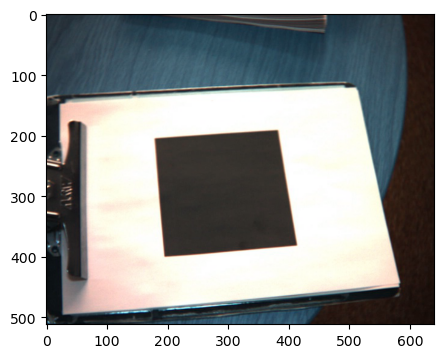

In [16]:
# Load all images in folder
images = []
nFrame = 0
folder = 'Pattern01/'
lst = os.listdir(folder)
lst.sort()

for frameNum in lst:
    images.append(cv.imread(folder+frameNum))
    nFrame += 1
# plot first image 
plt.imshow(images[0])
plt.show()


# Coordinates of the known target object (a dark square on a plane) in 3D:
XCart = np.array([[-50, -50,  50,  50],
          [50, -50, -50,  50],
            [0, 0, 0, 0]])

# These are some approximate intrinsics for this footage.
K = np.array([[640, 0, 320],
          [0, 512, 256],
            [0, 0, 1]])

# Define 3D points of wireframe object.
XWireFrameCart = np.array([[-50, -50,  50,  50, -50, -50,  50,  50],
          [50, -50, -50,  50, 50, -50, -50,  50],
            [0, 0, 0, 0, -100, -100, -100, -100, ]])

<font color="blue">**[Remarks]** Above image shows the first frame of the video we will be projecting a 3D cube on the tracked positions of the plane pattern.
</font>

<font color="blue">**[Remarks]** Below functions were defined in the _07_PracticalCondensation/labB.ipynb_. I have copied them from the lab **Homographies: Part 2**.
</font>

In [17]:
# This function is already defined in Lab Practical 2A

def projectiveCamera(K,T,XCart):
    ##TODO
    # The goal of this function is to project points in XCart through projective camera
    # defined by intrinsic matrix K and extrinsic matrix T. In essence, this function takes a set of points 
    # in 3D world space, XCart, and projects them into camera image space by applying the extrinsic matrix T 
    # and then applying the intrinsic matrix K.
    # 
    # There are three steps.
    # 1) Move from world space to camera space. 
    #            camera space points = extrinsics T * world space points 
    #
    # 2) Applying the intrinsics matrix to the camera space points after normalizing
    #           homogeneous image space points = K * normalized camera space points
    # 
    # 3) Move to image space cartesian points from image space homogeneous points, involves a 
    # normalization using the third row.

    # TO DO: Convert Cartesian 3d points XCart to homogeneous coordinates XHom
    XHom = np.concatenate((XCart, np.ones((1,XCart.shape[1]))), axis=0)

    # TO DO: Apply extrinsic matrix to XHom, to move to frame of reference of camera
    XHom = T@XHom
    
    # TO DO: Project points into normalized camera coordinates xCamHom (remove 4th row)
    xCamHom = XHom[0:3,:] / np.tile([XHom[3,:]],(3,1))
    
    # TO DO: Move points to image coordinates xImHom by applying intrinsic matrix
    xImHom = K@xCamHom

    # TO DO: Convert points back to Cartesian coordinates xImCart
    XImCart = xImHom[0:2,:] / np.tile([xImHom[2,:]],(2,1))

    return XImCart
    
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0. You can do this using SVD. Consult your notes! 
    # Hint: SVD will be involved. 
    u, s, vh = np.linalg.svd(A)
    h = (vh.T)[:,-1]
    return h

def calcBestHomography(pts1Cart, pts2Cart):
    
    # This function should apply the direct linear transform (DLT) algorithm to calculate the best 
    # homography that maps the cartesian points in pts1Cart to their corresonding matching cartesian poitns 
    # in pts2Cart.
    
    # This function calls solveAXEqualsZero. Make sure you are wary of how to reshape h into a 3 by 3 matrix. 

    n_points = pts1Cart.shape[1]
    
    # TO DO: replace this:
    H = np.identity(3)

    # TO DO: 
    # First convert points into homogeneous representation
    # Hint: we've done this before  in the skeleton code we provide.
    pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)
    
    # Then construct the matrix A, size (n_points * 2, 9)
    # Consult the notes!
    A = np.zeros((n_points * 2, 9))

    u = pts1Hom[0,:]
    v = pts1Hom[1,:]
    one = pts1Hom[2,:]
    x = pts2Cart[0,:]
    y = pts2Cart[1,:]

    for i in range (n_points):
        A[2*i] = np.array([0,0,0,-1*u[i], -1*v[i], -1*one[i], y[i]*u[i], y[i]*v[i], y[i]*one[i]])
        A[2*i+1] = np.array([u[i], v[i], one[i], 0, 0, 0, -1*x[i]*u[i], -1*x[i]*v[i], -1*x[i]*one[i]])

    # Solve Ah = 0 using solveAXEqualsZero and get h.
    h= solveAXEqualsZero(A)
    
    # Reshape h into the matrix H, values of h go first into rows of H
    H = h.reshape((3,3))
    
    return H

def estimatePlanePose(XImCart,XCart,K):
    # The goal of this function is to estimate the pose of a plane relative to camera (extrinsic matrix)
    # given points in image space xImCart, points in 3D world space XCart, and an intrinsics matrix K.
    
    # TO DO: replace this
    T = []

    # TO DO: Convert Cartesian image points XImCart to homogeneous representation XImHom
    XImHom = np.concatenate((XImCart, np.ones((1,XImCart.shape[1]))), axis=0)
    
    # TO DO: Convert image co-ordinates XImHom to normalized camera coordinates XCamHom    
    XCamHom = np.linalg.inv(K) @ XImHom
    
    # TO DO: Estimate homography H mapping homogeneous (x,y) coordinates of positions
    # in real world to XCamHom (convert XCamHom to Cartesian, calculate the homography) -
    # use the routine you wrote for Practical 1B
    H = calcBestHomography(XCart[:2,:], XCamHom[:2,:])
     
    # TO DO: Estimate first two columns of rotation matrix R from the first two
    # columns of H using the SVD. NOTE: You do not need to transpose v from linalg.svd    
    R = np.zeros((3,3))
    u,s,vh = np.linalg.svd(H[:,:2])
    R[:,:2] = u @ np.array([[1,0],[0,1],[0,0]]) @ vh

    # TO DO: Estimate the third column of the rotation matrix by taking the cross
    # product of the first two columns
    R[:,2] = np.cross(R[:,0], R[:,1])
    
    # TO DO: Check that the determinant of the rotation matrix is positive - if
    # not then multiply last column by -1.
    if not np.linalg.det(R) > 0:
        R[:,-1] = -1* R[:,-1]

    # TO DO: Estimate the translation t by finding the appropriate scaling factor k
    # and applying it to the third colulmn of H
    k = (H[:,:2]/R[:,:2]).sum()/6
    t = H[:,2]/k
    
    # TO DO: Check whether t_z is negative - if it is then multiply t by -1 and
    # the first two columns of R by -1.
    if t[2] < 0:
        t *= -1
        R[:,:2] *= -1
            
    # TO DO: Assemble transformation into matrix form
    T = np.hstack([R, t[:,None]])
    T = np.vstack([T, np.array([0,0,0,1])])
    
    return T

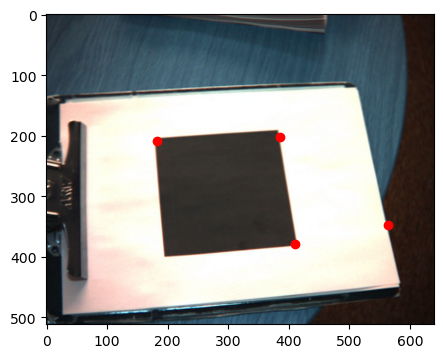

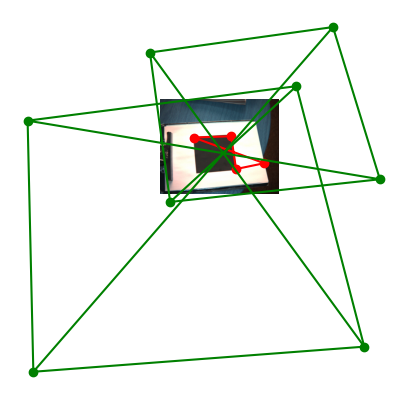

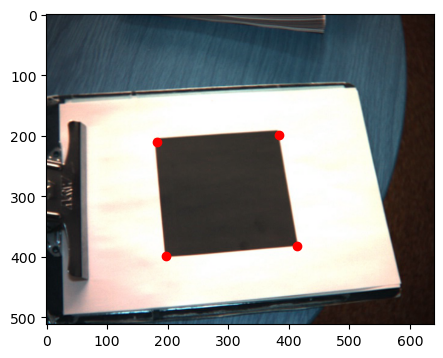

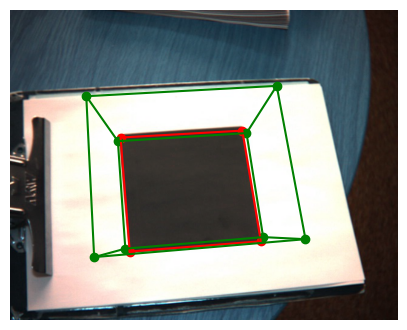

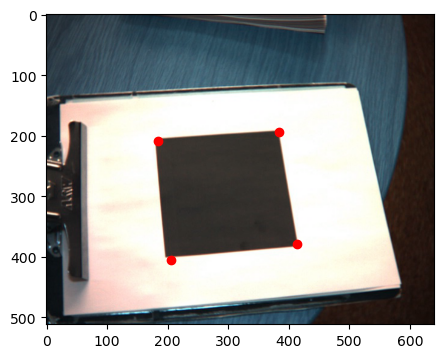

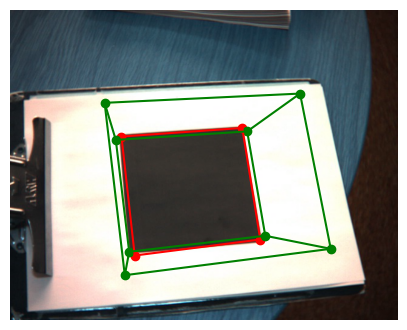

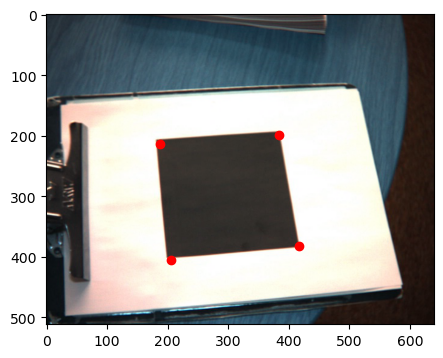

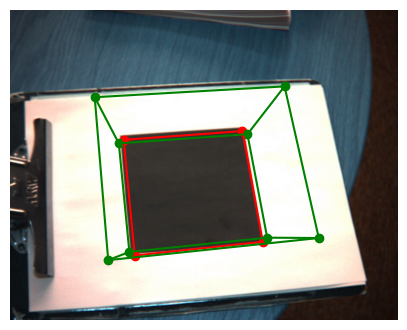

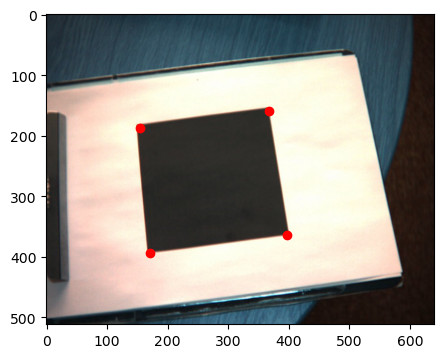

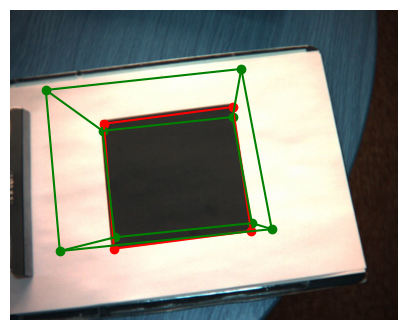

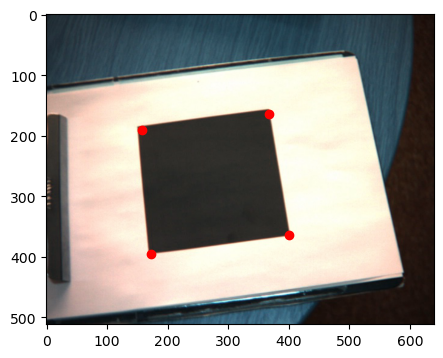

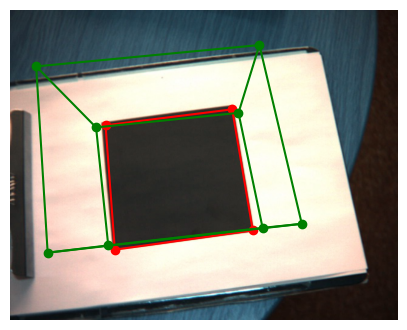

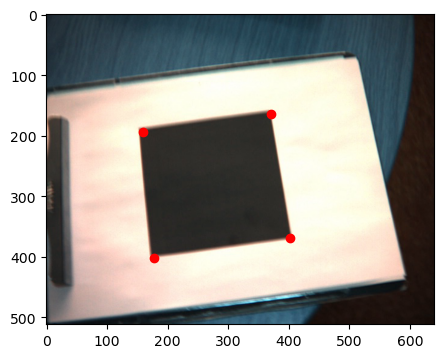

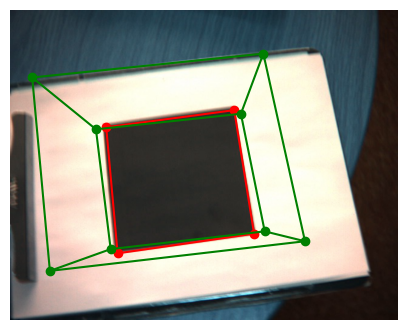

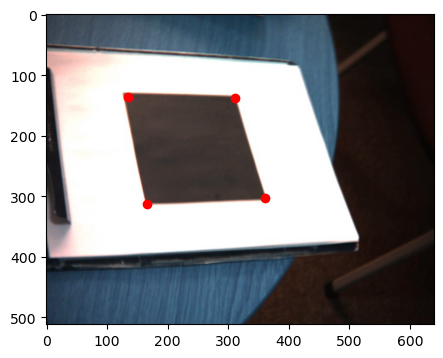

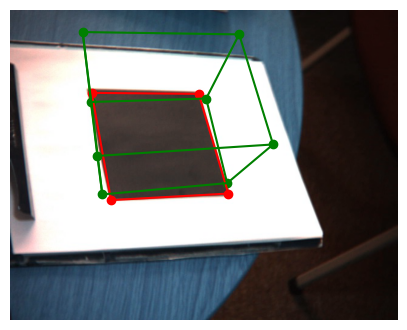

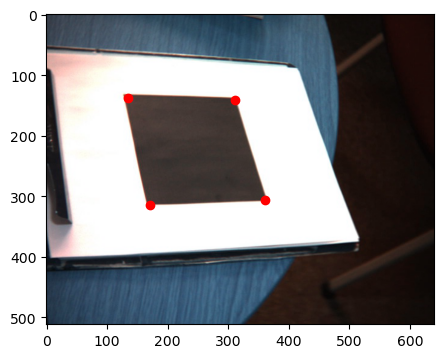

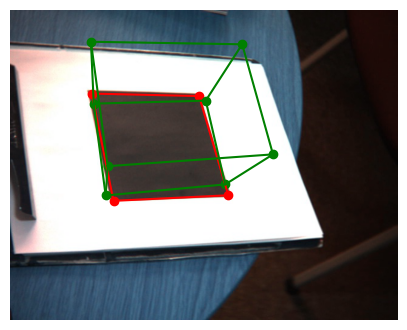

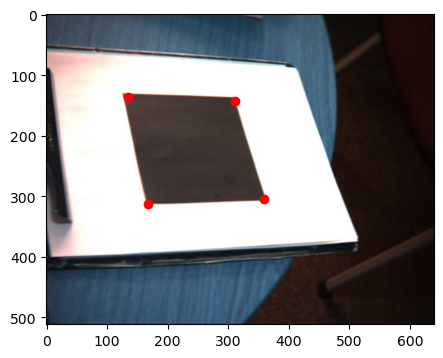

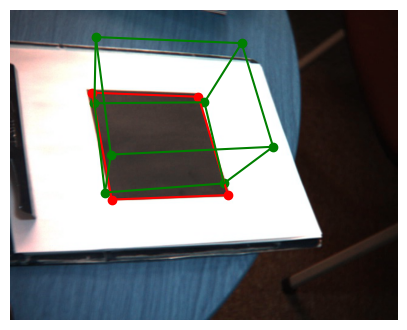

In [18]:
# ================================================
for iFrame in range(nFrame):

    # Only print 3 frames from each position in the clip: beginning, half-way, ending
    if iFrame in [0, 1, 2, 3, int(nFrame/2)-2, int(nFrame/2)-1, int(nFrame/2), nFrame-3, nFrame-2, nFrame-1]:
        printFrame = True
    else:
        printFrame = False


    xImCart = np.array([LLs[iFrame,:].T, ULs[iFrame,:].T, URs[iFrame,:].T, LRs[iFrame,:].T]).T

    # get a frame from footage 
    im = images[iFrame]

    if printFrame:
        # Draw image and 2d points
        plt.imshow(im)
        plt.scatter(x = xImCart[0,:], y = xImCart[1,:],c = 'r')
        plt.show()


    #TO DO: Use your routine to calculate TEst the extrinsic matrix relating the
    #plane position to the camera position.
    T = estimatePlanePose(xImCart, XCart, K);

    
    
    # TO DO: Draw a wire frame cube using data XWireFrameCart. You need to
    # 1) project the vertices of a 3D cube through the projective camera;
    # 2) draw lines betweeen the resulting 2d image points.
    # Note: CONDUCT YOUR CODE FOR DRAWING XWireFrameCart HERE

    XWireFrameCartProjected = projectiveCamera(K, T, XWireFrameCart)
    if printFrame:
        # Draw image
        plt.imshow(im)

        # draw the 2d points
        plt.scatter(x=xImCart[0,:], y=xImCart[1,:], c='r')

        # draw the lines between the 2d points
        plt.plot(np.append(xImCart[0,:], xImCart[0,0]),np.append(xImCart[1,:], xImCart[1,0]),'r')

        # draw the vertices of the projected 3D cube
        plt.scatter(x=XWireFrameCartProjected[0,:], y=XWireFrameCartProjected[1,:], c='g')
        
        # draw the lines on the bottom of the projected 3D cube
        plt.plot(np.append(XWireFrameCartProjected[0,:4], XWireFrameCartProjected[0,0]),np.append(XWireFrameCartProjected[1,:4], XWireFrameCartProjected[1,0]),'g')
        
        # draw the lines of the top of the projected 3D cube
        plt.plot(np.append(XWireFrameCartProjected[0,4:], XWireFrameCartProjected[0,4]),np.append(XWireFrameCartProjected[1,4:], XWireFrameCartProjected[1,4]),'g')
        
        # draw the lines of the sides of the projected 3D cube
        plt.plot(np.array([XWireFrameCartProjected[0,0], XWireFrameCartProjected[0,4]]),np.array([XWireFrameCartProjected[1,0], XWireFrameCartProjected[1,4]]),'g')
        plt.plot(np.array([XWireFrameCartProjected[0,1], XWireFrameCartProjected[0,5]]),np.array([XWireFrameCartProjected[1,1], XWireFrameCartProjected[1,5]]),'g')
        plt.plot(np.array([XWireFrameCartProjected[0,2], XWireFrameCartProjected[0,6]]),np.array([XWireFrameCartProjected[1,2], XWireFrameCartProjected[1,6]]),'g')
        plt.plot(np.array([XWireFrameCartProjected[0,3], XWireFrameCartProjected[0,7]]),np.array([XWireFrameCartProjected[1,3], XWireFrameCartProjected[1,7]]),'g')
        
        # disable the two axes
        plt.axis('off')

        # show the plot
        plt.show()
    


<font color="blue">**[Remarks]** <br>

In order to project a 3D cube on the given pattern in each video frame, we firstly use the particle filter method to track the positions of the four corners of the plane pattern. Then, we transformed the coodinates from the tracking into homogeneous form, and compute the extrinsic matrix relating the plane position to the camera position through recovering the best homography H. Lastly, we project the vertices and draw the wireframe of a 3D cube through the projective camera for each frame.

Due to the limitation of the notebook file size (if the file size is too big, it would crash the Python kernel), I only display 9 frames in total (first 3, middle 3 and last 3). For each frame, we see that we successfully project a wireframe 3D cube (in green) roughly on top of the estimated plane position (4 corners marked in red). However, we have a very inaccurate result for first frame, which we will further discuss later on.

The results are a bit different from what we expect. It is expected that the bottom 4 green dots should be positioned at the same places as the red dots denoting the 4 cornors of the plane. However, the green dots in the image are not fully aligning with the red dots, depsite being in close proximity. As noted in the Prince's book (P.400), the direct linear transformation method with homogeneous coordinates that we used above to learn the projective parameters is not exactly the same as optimising the true objective function, which would explain the differences. But this method allows us to compute a closed form solution and serves a close-enough starting point for the non-linear optimisation of the true criterion.

It is worthwhile to point out that the tracked positions could be quite off especially for earlier frames. For example, we got a completely wrong point for the lower-left corner in the first frame, mostly due to not having any particle on the true position of the lower-left corner of the pattern. The resulting projected 3D cube looks twisted and inaccurate because the 4 points passed in as the plane position are not correct.

Below are two changes that could help improve our results:
1. Increase the number of particles - By having more particles, there is a higher chance that at least one particle will fall onto the true position of the corner of the pattern (with the highest likelihood) for every frame. This could reduce the chance of having similar case like our first frame, where we have twisted 3D cube due to a completely misplaced corner point.<br>
2. Incorporate the acceleration in w - By capturing an additional factor, we have a better insight on where potentially the true corner positions locate in the next frame. This would increase the chance to have new particles generated on top of the true positions. But it is important to note that by increasing the dimension of w, we would need to signifantly increase the number of particles as the explorable space has expanded to a new dimension.
</font>